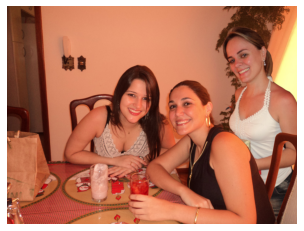

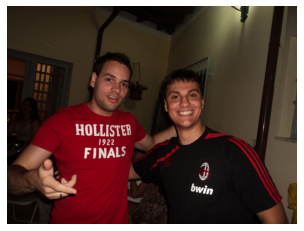





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).



Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/cam_256/-30


100%|██████████| 48/48 [00:00<00:00, 159.82it/s]


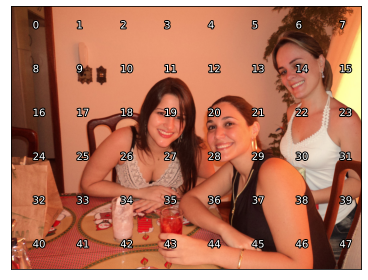

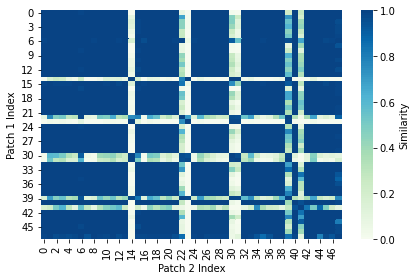

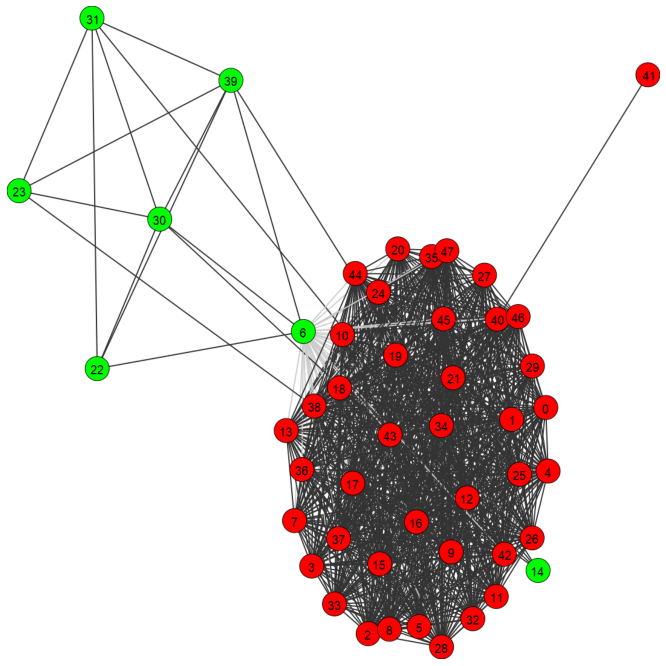

INFO:tensorflow:Restoring parameters from ./models/cam_256/-30


100%|██████████| 48/48 [00:00<00:00, 161.35it/s]


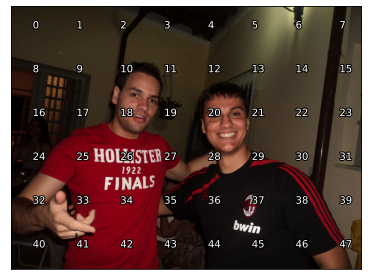

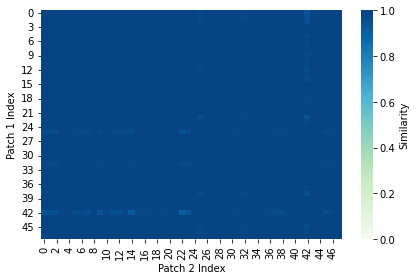

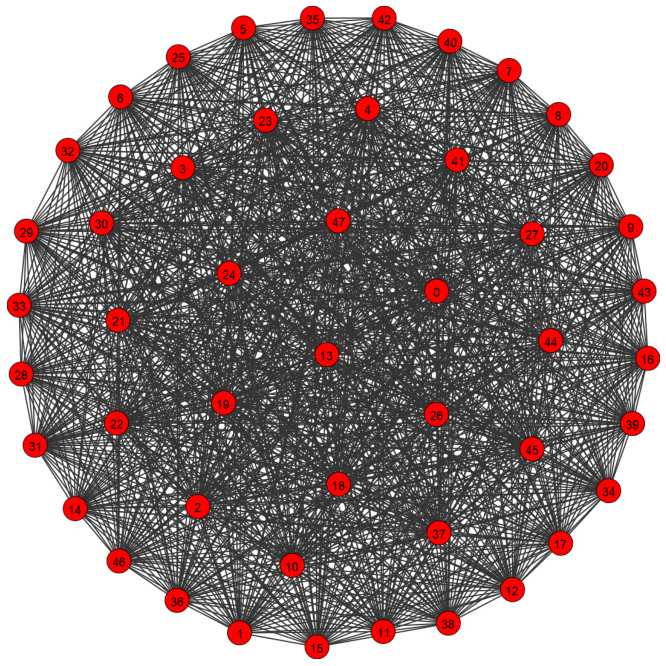

INFO:tensorflow:Restoring parameters from ./models/cam_256/-30


100%|██████████| 165/165 [00:02<00:00, 82.43it/s]


INFO:tensorflow:Restoring parameters from ./models/cam_256/-30


100%|██████████| 165/165 [00:01<00:00, 89.84it/s]


Spliced: Spectral Gap = 10.49
Spliced: Normalized Spectral Gap = 0.4321
Spliced: Modularity Value = 0.0293
Authentic: Spectral Gap = 161.89
Authentic: Normalized Spectral Gap = 1.0027
Authentic: Modularity Value = 0.0060
INFO:tensorflow:Restoring parameters from ./models/cam_128/-30


100%|██████████| 2745/2745 [07:28<00:00,  6.12it/s]


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

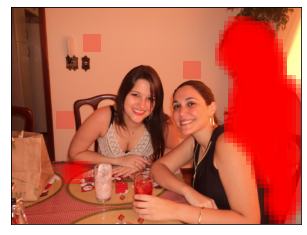

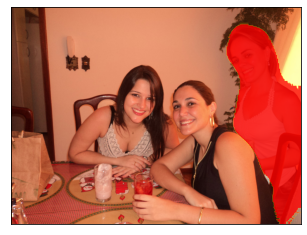

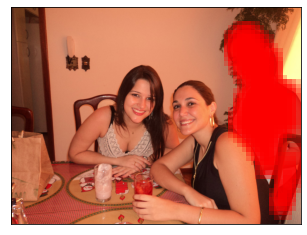

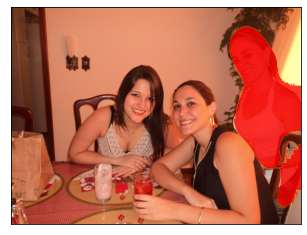

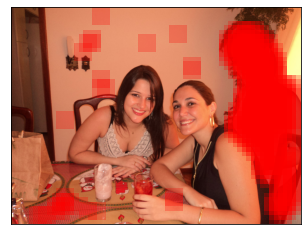

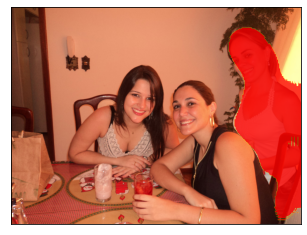

In [1]:
from src.simgraph import calc_simgraph
import matplotlib.pyplot as plt
import igraph as ig
from src.graph_utils import adj_to_graph, sym_mat
import numpy as np
import src.spectral_utils as su
import src.graph_utils as gu
import src.localization as localization

f1 = './testimages/splicing-01.TIF' #spliced image
f2 = './testimages/normal-01.TIF' #authentic image

#f1 = './testimages/tampered.TIF' #spliced image
#f2 = './testimages/real.TIF' #authentic image

fweights = './models/cam_256/-30' #path to model CNN weights
patch_size = 256 #patch size, must match associated weights file
overlap = 0

#show both images
I1 = plt.imread(f1)[:,:,:3]
plt.imshow(I1)
plt.axis('off')
plt.show()

I2 = plt.imread(f2)[:,:,:3]
plt.imshow(I2)
plt.axis('off')
plt.show()

#compute similarity graph for image 1 (spliced)
sg1 = calc_simgraph(image = I1,
                    f_weights_restore = fweights, patch_size = patch_size,
                    overlap = overlap)

#plot index overlay for sampled patches
sg1.plot_indices(image=I1)

#plot forensic similarity matrix, which will be used later for creating the graph
sg1.plot_matrix()

M = sym_mat(sg1.mat) #make the similarity matrix symmetric
np.fill_diagonal(M, 0) #set diagonals to zero (doesn't matter for calculations, just makes the plot look nicer)
g = adj_to_graph(M,threshold=0.9) #convert to igraph representation
c = g.community_fastgreedy(weights=g.es['weight']) #compute community structure

ig.plot(c.as_clustering(n=2), 'temp_graph.png', bbox = (1080,1080), #plot it
        layout = 'kk', vertex_label_size=20, vertex_size=40, edge_width=2)

#you can play around with some other force directed layout methods:
#layout = 'kk' uses kamada-kawaii force directed layout 
#layout = 'fr' Fruchterman-Reingold
#layout = 'grid_fr' Grid Fruchterman-Reingold
#layout = 'drl' Distributed Recursive Layout
f,ax = plt.subplots(1,figsize=(12,12))
ax.imshow(plt.imread('temp_graph.png'))
ax.set_axis_off()
plt.show()

#compute similarity graph for image 2 (authentic)
sg2 = calc_simgraph(image = I2,
                    f_weights_restore = fweights, patch_size = patch_size,
                    overlap = overlap)
#plot index overlay for sampled patches
sg2.plot_indices(image=I2)

#plot forensic similarity matrix, which will be used later for creating the graph
sg2.plot_matrix()

M = sym_mat(sg2.mat) #make the similarity matrix symmetric
np.fill_diagonal(M, 0) #set diagonals to zero (doesn't matter for calculations, just makes the plot look nicer)
g = adj_to_graph(M,threshold=0.9) #convert to igraph representation
c = g.community_fastgreedy(weights=g.es['weight']) #compute community structure

ig.plot(c.as_clustering(), 'temp_graph.png', bbox = (1080,1080), #plot it
        layout = 'kk', vertex_label_size=20, vertex_size=40, edge_width=2)

f,ax = plt.subplots(1,figsize=(12,12))
ax.imshow(plt.imread('temp_graph.png'))
ax.set_axis_off()
plt.show()


fweights = './models/cam_256/-30' #path to model CNN weights
patch_size = 256 #patch size, must match associated weights file
overlap = 128 #patch sampling overlap

#compute forensic similarity graphs for both images
#see example 0 for what they look like
I1 = plt.imread(f1)[:,:,:3]
sg1 = calc_simgraph(image = I1,
                    f_weights_restore = fweights, patch_size = patch_size,
                    overlap = overlap)

I2 = plt.imread(f2)[:,:,:3]
sg2 = calc_simgraph(image = I2,
                    f_weights_restore = fweights, patch_size = patch_size,
                    overlap = overlap)

## Forgery Detection - spliced image
#Low spectral gap (<100, or <0.5 normalized) values are indication of tampering
#high modularity values (>0.025) are indication of tampering

M = gu.sym_mat(sg1.mat) #symmetric similarity matrix for spliced image

L = su.laplacian(M) #laplacian matrix
gap = su.eigap01(L) #spectral gap
print(f'Spliced: Spectral Gap = {gap:.2f}')

normL = su.laplacian(M, laplacian_type='sym') #normalized laplacian matrix
normgap = su.eigap01(normL) #normalized spectral gap
print(f'Spliced: Normalized Spectral Gap = {normgap:.4f}')

g = gu.adj_to_graph(M) #convert to igraph Graph object
_, _, mod = gu.cluster_fastgreedy(g,weighted=True) #compute modularity
print(f'Spliced: Modularity Value = {mod:.4f}')


## Forgery Detection - authentic image
#Low spectral gap (<100, or <0.5 normalized) values are indication of tampering
#high modularity values (>0.025) are indication of tampering

M = gu.sym_mat(sg2.mat) #symmetric similarity matrix for spliced image

L = su.laplacian(M) #laplacian matrix
gap = su.eigap01(L) #spectral gap
print(f'Authentic: Spectral Gap = {gap:.2f}')

normL = su.laplacian(M, laplacian_type='sym') #normalized laplacian matrix
normgap = su.eigap01(normL) #normalized spectral gap
print(f'Authentic: Normalized Spectral Gap = {normgap:.4f}')

g = gu.adj_to_graph(M) #convert to igraph Graph object
_, _, mod = gu.cluster_fastgreedy(g,weighted=True) #compute modularity
print(f'Authentic: Modularity Value = {mod:.4f}')





f1 = './testimages/splicing-01.TIF' #spliced image

fweights = './models/cam_128/-30' #path to model CNN weights
patch_size = 128 #patch size, must match associated weights file
overlap = 96 #patch sampling overlap

#compute forensic similarity graphs for the spliced image
I1 = plt.imread(f1)[:,:,:3]
sg1 = calc_simgraph(image = I1,
                    f_weights_restore = fweights, patch_size = patch_size,
                    overlap = overlap)

## Forgery Localization - Modularity Optimization
M = gu.sym_mat(sg1.mat) #symmetric similarity matrix for spliced image
g = gu.adj_to_graph(M, threshold=0.7) #convert to igraph Graph object
com, n, mod = gu.cluster_fastgreedy(g,n=2,weighted=True) #compute modularity

pat_loc = localization.PatchLocalization(inds = sg1.inds, patch_size = patch_size,
                                        prediction = com.membership)

f = pat_loc.plot_heatmap(image=I1)

pix_loc = localization.pixel_loc_from_patch_pred(prediction=pat_loc.prediction,
                                                 inds = sg1.inds,
                                                 patch_size = patch_size,
                                                 image_shape = I1.shape[:2],
                                                 threshold = 0.5)


#pat_loc.pixel_mask()
pix_loc.plot(image=I1)

## Forgery Localization - Spectral Clustering
L = su.laplacian(M)
prediction = su.spectral_cluster(L)

pat_loc = localization.PatchLocalization(inds = sg1.inds, patch_size = patch_size,
                                        prediction = prediction)

f = pat_loc.plot_heatmap(image=I1,label=0)
#here we flip the label for easier visualization..
#note the label=0 in the line above (default=1)
#and the ~pat_loc.prediction in the line below
pix_loc = localization.pixel_loc_from_patch_pred(prediction=~pat_loc.prediction,
                                                 inds = sg1.inds,
                                                 patch_size = patch_size,
                                                 image_shape = I1.shape[:2],
                                                 threshold = 0.37)



pix_loc.plot(image=I1)

## Forgery Localization - Normalized Spectral Clustering
L = su.laplacian(M,laplacian_type='sym')
#normalization is performed with the laplacian_type parameter (default is None)
#otherwise the analysis is the same

prediction = su.spectral_cluster(L)

pat_loc = localization.PatchLocalization(inds = sg1.inds, patch_size = patch_size,
                                        prediction = ~prediction)
f = pat_loc.plot_heatmap(image=I1,label=0)
#here we flip the label for easier visualization..
#note the label=0 in the line above
#and the ~pat_loc.prediction in the line below
pix_loc = localization.pixel_loc_from_patch_pred(prediction=~pat_loc.prediction,
                                                 inds = sg1.inds,
                                                 patch_size = patch_size,
                                                 image_shape = I1.shape[:2],
                                                 threshold = 0.5)

pix_loc.plot(image=I1)

